In [ ]:
# Load this data set https://huggingface.co/datasets/armanc/pubmed-rct20k
from datasets import load_dataset
from typing import Iterator, Optional
import re
from tqdm.auto import tqdm
import time

def preprocess_string(text: str) -> str:
    """Modern preprocessing function with better text cleaning"""
    # Remove special characters and normalize whitespace
    text = re.sub(r'@\s+', '', text)  # Remove @ symbols
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.strip().lower()

class PubMedCorpus:
    """Modern corpus iterator for PubMed RCT dataset"""
    
    def __init__(self, splits: list[str] = None, max_examples: Optional[int] = None):
        # Default to all splits if none specified
        if splits is None:
            splits = ['train', 'validation', 'test']
        
        # Load the dataset splits in streaming mode to avoid loading all into memory
        print(f"🔄 Loading PubMed dataset (splits: {', '.join(splits)})...")
        datasets = []
        with tqdm(total=len(splits), desc="Loading dataset splits", unit="split") as pbar:
            for split in splits:
                ds = load_dataset("armanc/pubmed-rct20k", split=split, streaming=True)
                datasets.append(ds)
                pbar.update(1)
            time.sleep(0.5)  # Brief pause to show progress
        
        # Concatenate all datasets using interleave for efficient streaming
        from itertools import chain
        self.datasets = datasets
        self.max_examples = max_examples
        print(f"✅ Dataset loaded successfully! Splits: {', '.join(splits)}, Max examples: {max_examples or 'unlimited'}")

    def __iter__(self) -> Iterator[str]:
        from itertools import chain
        count = 0
        for dataset in self.datasets:
            for example in dataset:
                if self.max_examples and count >= self.max_examples:
                    return
                # Use correct field name 'text' instead of 'abstract'
                text = example.get('text', '')
                # Perform text preprocessing
                yield preprocess_string(text)
                count += 1
    
    def get_labels_and_text(self) -> Iterator[tuple[int, str]]:
        """Iterator that yields (label, text) pairs"""
        count = 0
        for dataset in self.datasets:
            for example in dataset:
                if self.max_examples and count >= self.max_examples:
                    return
                label = example.get('label')
                text = example.get('text', '')
                if label is not None:
                    yield label, preprocess_string(text)
                    count += 1
    
    def get_raw_examples(self) -> Iterator[dict]:
        """Iterator that yields raw dataset examples for analysis"""
        count = 0
        for dataset in self.datasets:
            for example in dataset:
                if self.max_examples and count >= self.max_examples:
                    return
                yield example
                count += 1

# Create the corpus iterator with limit for demonstration
corpus = PubMedCorpus(max_examples=5)

# Example: iterate through first few documents
print("\n📖 Processing first few documents...")
with tqdm(total=3, desc="Processing documents", unit="doc") as pbar:
    for i, doc in enumerate(corpus):
        if i >= 3:  # Show first 3 documents
            break
        print(f"Document {i+1}: {doc[:100]}...")  # Show first 100 characters
        pbar.update(1)
        time.sleep(0.2)  # Brief pause to show progress
    
# Show example with labels
print("\n🏷️ Processing samples with labels...")
labeled_corpus = PubMedCorpus(max_examples=3)
with tqdm(total=3, desc="Processing labeled samples", unit="sample") as pbar:
    for label, text in labeled_corpus.get_labels_and_text():
        print(f"Label {label}: {text[:80]}...")
        pbar.update(1)
        time.sleep(0.2)  # Brief pause to show progress

🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits:   0%|          | 0/3 [00:00<?, ?split/s]d:\santi\Documents\MAIA\Bimestre 2026-11\Microproyecto\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\santi\.cache\huggingface\hub\datasets--armanc--pubmed-rct20k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Repo card metadata bl

✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: 5

📖 Processing first few documents...


Processing documents:  33%|███▎      | 1/3 [00:01<00:02,  1.09s/doc]

Document 1: to investigate the efficacy of weeks of daily low-dose oral prednisolone in improving pain , mobilit...


Processing documents: 100%|██████████| 3/3 [00:01<00:00,  2.50doc/s]

Document 2: a total of patients with primary knee oa were randomized @:; received mg/day of prednisolone and rec...
Document 3: outcome measures included pain reduction and improvement in function scores and systemic inflammatio...


Processing documents: 100%|██████████| 3/3 [00:01<00:00,  1.77doc/s]



🏷️ Processing samples with labels...
🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.05s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: 3


Processing labeled samples:  33%|███▎      | 1/3 [00:00<00:01,  1.15sample/s]

Label objective: to investigate the efficacy of weeks of daily low-dose oral prednisolone in impr...
Label methods: a total of patients with primary knee oa were randomized @:; received mg/day of ...


Processing labeled samples: 100%|██████████| 3/3 [00:01<00:00,  2.03sample/s]

Label methods: outcome measures included pain reduction and improvement in function scores and ...


In [ ]:
# Show first 5 examples as a pandas DataFrame with labels and text
import pandas as pd

# Create DataFrame with both text and labels using modern approach
print("\n📊 Creating DataFrame with sample data...")
corpus = PubMedCorpus(max_examples=5)
data = []

with tqdm(total=5, desc="Collecting data for DataFrame", unit="example") as pbar:
    for label, text in corpus.get_labels_and_text():
        data.append({
            'label': label,
            'text_preview': text[:200] + '...' if len(text) > 200 else text,
            'text_length': len(text)
        })
        pbar.update(1)
        time.sleep(0.1)  # Brief pause to show progress

print("\n🗂️ Processing DataFrame...")
with tqdm(total=1, desc="DataFrame processing", unit="step") as pbar:
    # Create DataFrame
    pbar.set_description("Creating DataFrame")
    df = pd.DataFrame(data)
    pbar.update(1)
    time.sleep(0.2)

print("✅ DataFrame creation completed!")
print("\n📋 Sample data:")
df


📊 Creating DataFrame with sample data...
🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:02<00:00,  1.04split/s]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: 5



🗂️ Processing DataFrame...


Creating DataFrame: 100%|██████████| 1/1 [00:00<00:00,  4.96step/s]

✅ DataFrame creation completed!

📋 Sample data:


,label,text_preview,text_length
0,objective,to investigate the efficacy of weeks of daily ...,277
1,methods,a total of patients with primary knee oa were ...,125
2,methods,outcome measures included pain reduction and i...,111
3,methods,pain was assessed using the visual analog pain...,63
4,methods,secondary outcome measures included the wester...,209


In [ ]:
# Show the dataset structure and column information using corpus
# Inspect dataset structure through the corpus class
corpus = PubMedCorpus(max_examples=1)
first_example = next(corpus.get_raw_examples())

print("Dataset columns:", list(first_example.keys()))
print("\nColumn details:")
for key, value in first_example.items():
    if isinstance(value, (list, dict)):
        print(f"  {key}: {type(value).__name__} (length: {len(value) if hasattr(value, '__len__') else 'N/A'})")
    else:
        print(f"  {key}: {type(value).__name__} = {value}")

🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.00s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: 1
Dataset columns: ['abstract_id', 'label', 'text', 'sentence_id']

Column details:
  abstract_id: str = 24293578
  label: str = objective
  text: str = To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
  sentence_id: int = 0


In [ ]:
# Analyze unique labels in the dataset using corpus
from collections import Counter

# Use corpus to analyze the full dataset label distribution
corpus = PubMedCorpus()  # Use full dataset
label_counter = Counter()
labels_seen = set()

print("Analyzing labels from the full dataset using corpus...")
for example in corpus.get_raw_examples():
    if 'label' in example:
        val = example['label']
        if isinstance(val, list):
            labels_seen.update(val)
            label_counter.update(val)
        else:
            labels_seen.add(val)
            label_counter[val] += 1

print(f"Unique labels found: {sorted(labels_seen)}")
print(f"Label distribution: {dict(label_counter.most_common())}")

print("\nLabel statistics:")
for label in sorted(labels_seen):
    count = label_counter.get(label, 0)
    print(f"  {label}: {count:,} examples")

🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.09s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: unlimited
Analyzing labels from the full dataset using corpus...
Unique labels found: ['background', 'conclusions', 'methods', 'objective', 'results']
Label distribution: {'methods': 79113, 'results': 77507, 'conclusions': 36321, 'background': 24404, 'objective': 18547}

Label statistics:
  background: 24,404 examples
  conclusions: 36,321 examples
  methods: 79,113 examples
  objective: 18,547 examples
  results: 77,507 examples


🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.10s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: unlimited
Analyzing class balance from the full dataset...


<ipython-input-13-f67108265e57>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=balance_df, x='label', y='count', ax=ax1, palette='viridis')


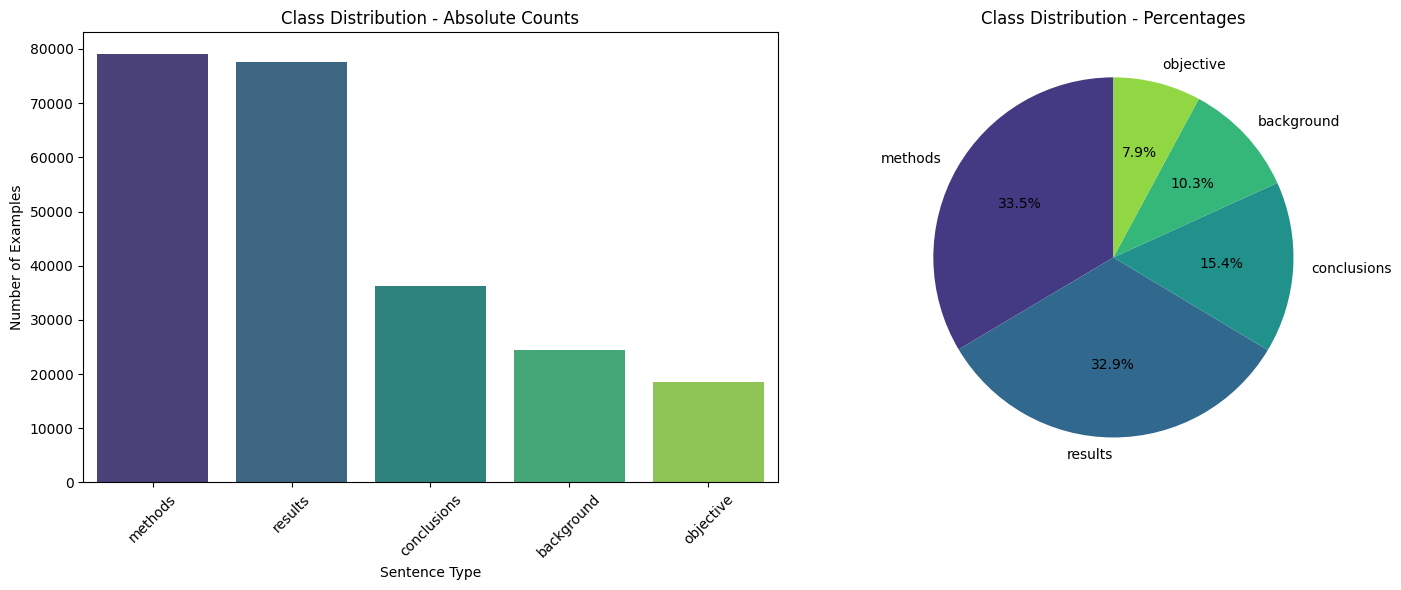


Class Balance Statistics:
      label  count  percentage
    methods  79113   33.537805
    results  77507   32.856985
conclusions  36321   15.397300
 background  24404   10.345412
  objective  18547    7.862496


In [ ]:
# Class Balance Analysis - Visualize label distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Create corpus for comprehensive analysis using full dataset
corpus = PubMedCorpus()  # Use full dataset
label_counter = Counter()

print("Analyzing class balance from the full dataset...")
for example in corpus.get_raw_examples():
    if 'label' in example:
        label_counter[example['label']] += 1

# Create DataFrame for visualization
balance_data = []
for label, count in label_counter.items():
    balance_data.append({
        'label': label,
        'count': count,
        'percentage': count / sum(label_counter.values()) * 100
    })

balance_df = pd.DataFrame(balance_data)
balance_df = balance_df.sort_values('count', ascending=False)

# Visualize class balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot with counts
sns.barplot(data=balance_df, x='label', y='count', ax=ax1, palette='viridis')
ax1.set_title('Class Distribution - Absolute Counts')
ax1.set_xlabel('Sentence Type')
ax1.set_ylabel('Number of Examples')
ax1.tick_params(axis='x', rotation=45)

# Pie chart with percentages
colors = sns.color_palette('viridis', len(balance_df))
ax2.pie(balance_df['count'], labels=balance_df['label'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Class Distribution - Percentages')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nClass Balance Statistics:")
print(balance_df.to_string(index=False))

🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.19s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: unlimited
Discovering unique labels...
🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.16s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: unlimited
Analyzing stop words per class from the full dataset...


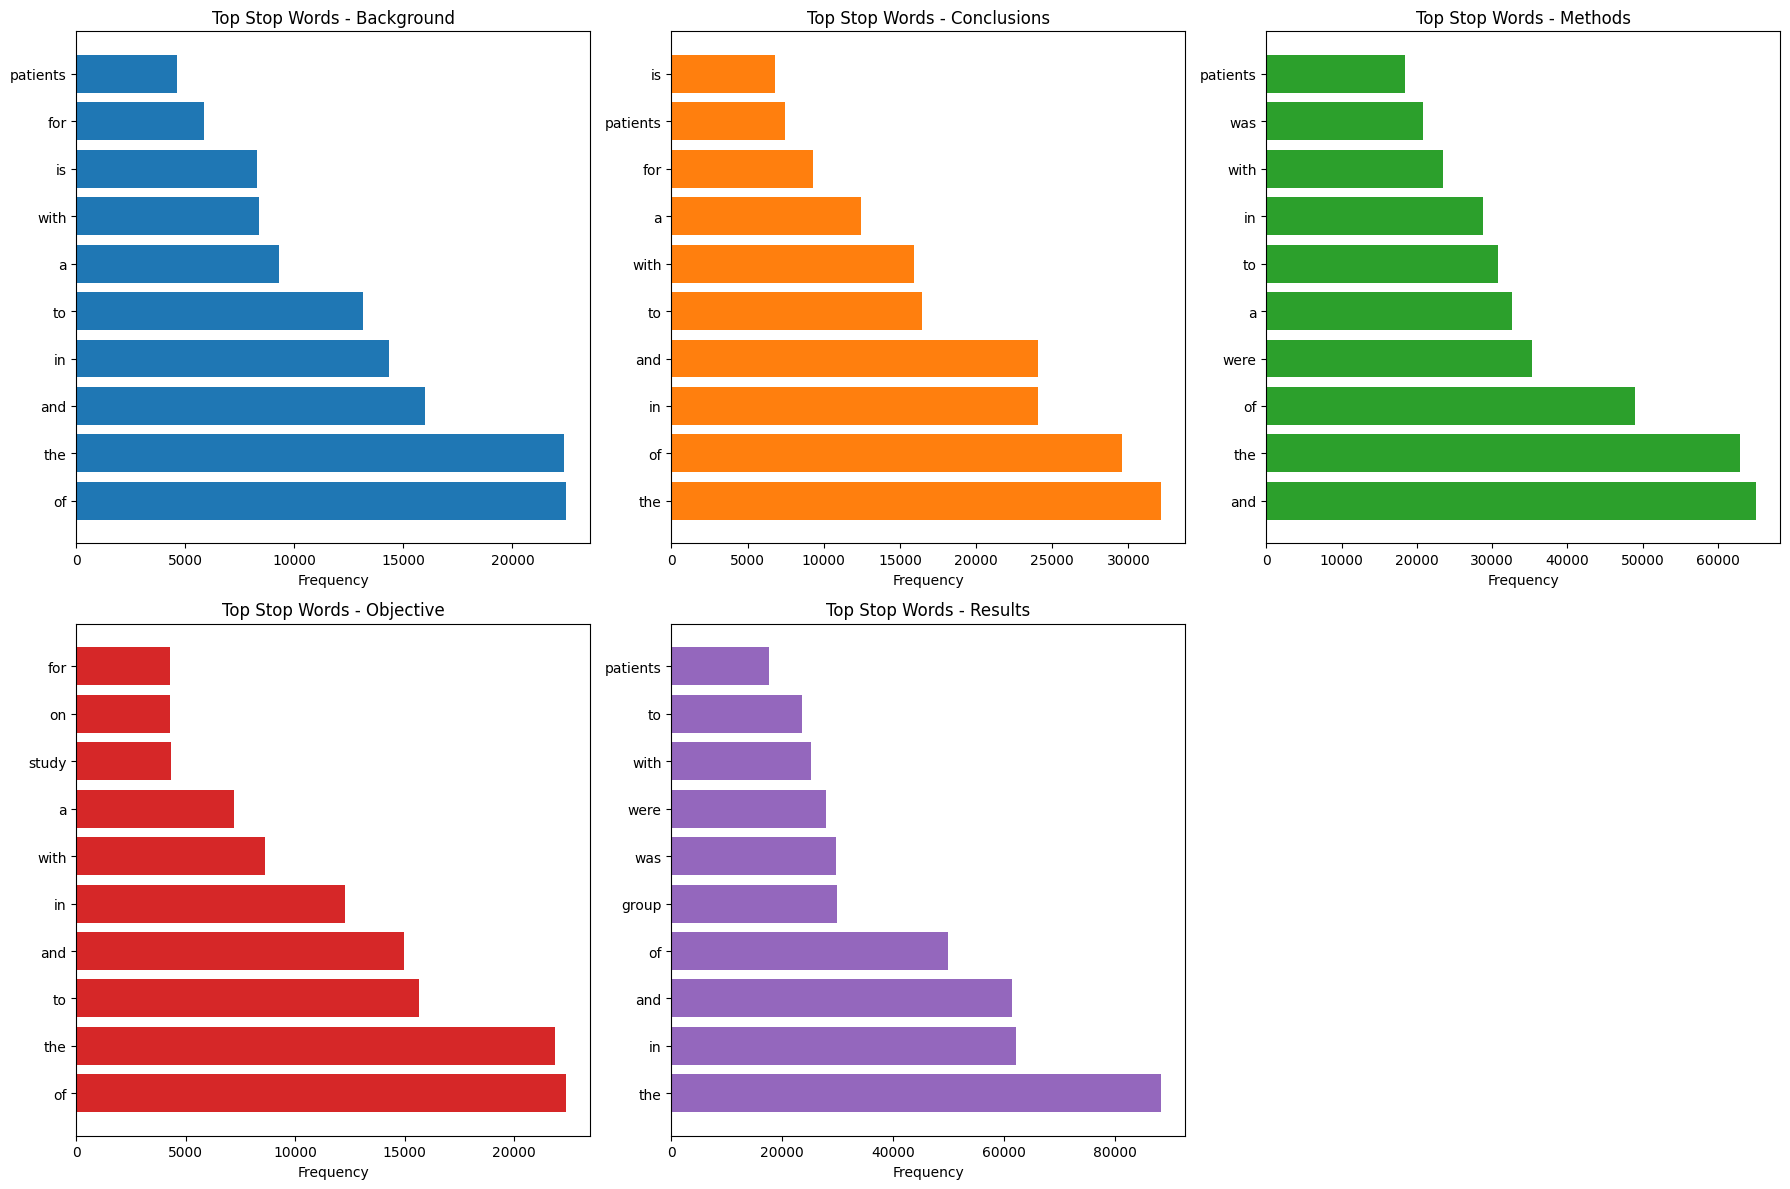

In [ ]:
# Stop Words Analysis per Class
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Get English stop words
english_stopwords = set(stopwords.words('english'))
# Add domain-specific stop words for medical texts
medical_stopwords = {'patients', 'study', 'treatment', 'weeks', 'days', 'results', 
                     'clinical', 'trial', 'group', 'compared', 'significant',
                     'analysis', 'data', 'methods', 'conclusion'}
all_stopwords = english_stopwords.union(medical_stopwords)

# Analyze stop words per class
corpus = PubMedCorpus()  # Use full dataset
# First pass to get unique labels
print("Discovering unique labels...")
unique_labels = set()
for example in corpus.get_raw_examples():
    if 'label' in example:
        unique_labels.add(example['label'])
    if len(unique_labels) >= 10:  # Assume we found all labels after seeing many examples
        break

class_texts = {label: [] for label in unique_labels}
class_stopwords = {label: Counter() for label in unique_labels}

corpus = PubMedCorpus()  # Recreate corpus for full iteration
print("Analyzing stop words per class from the full dataset...")
for example in corpus.get_raw_examples():
    if 'label' in example:
        label = example['label']
        text = preprocess_string(example.get('text', ''))
        class_texts[label].append(text)
        
        # Tokenize and count stop words
        tokens = word_tokenize(text)
        stop_words_in_text = [word for word in tokens if word.lower() in all_stopwords]
        class_stopwords[label].update(stop_words_in_text)

# Visualize top stop words per class
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, label in enumerate(sorted(unique_labels)):
    if i < len(axes):
        top_stopwords = class_stopwords[label].most_common(10)
        if top_stopwords:
            words, counts = zip(*top_stopwords)
            
            axes[i].barh(range(len(words)), counts, color=f'C{i}')
            axes[i].set_yticks(range(len(words)))
            axes[i].set_yticklabels(words)
            axes[i].set_title(f'Top Stop Words - {label.title()}')
            axes[i].set_xlabel('Frequency')

# Remove empty subplots
for i in range(len(unique_labels), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.13s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: unlimited
Generating word clouds from the full dataset...


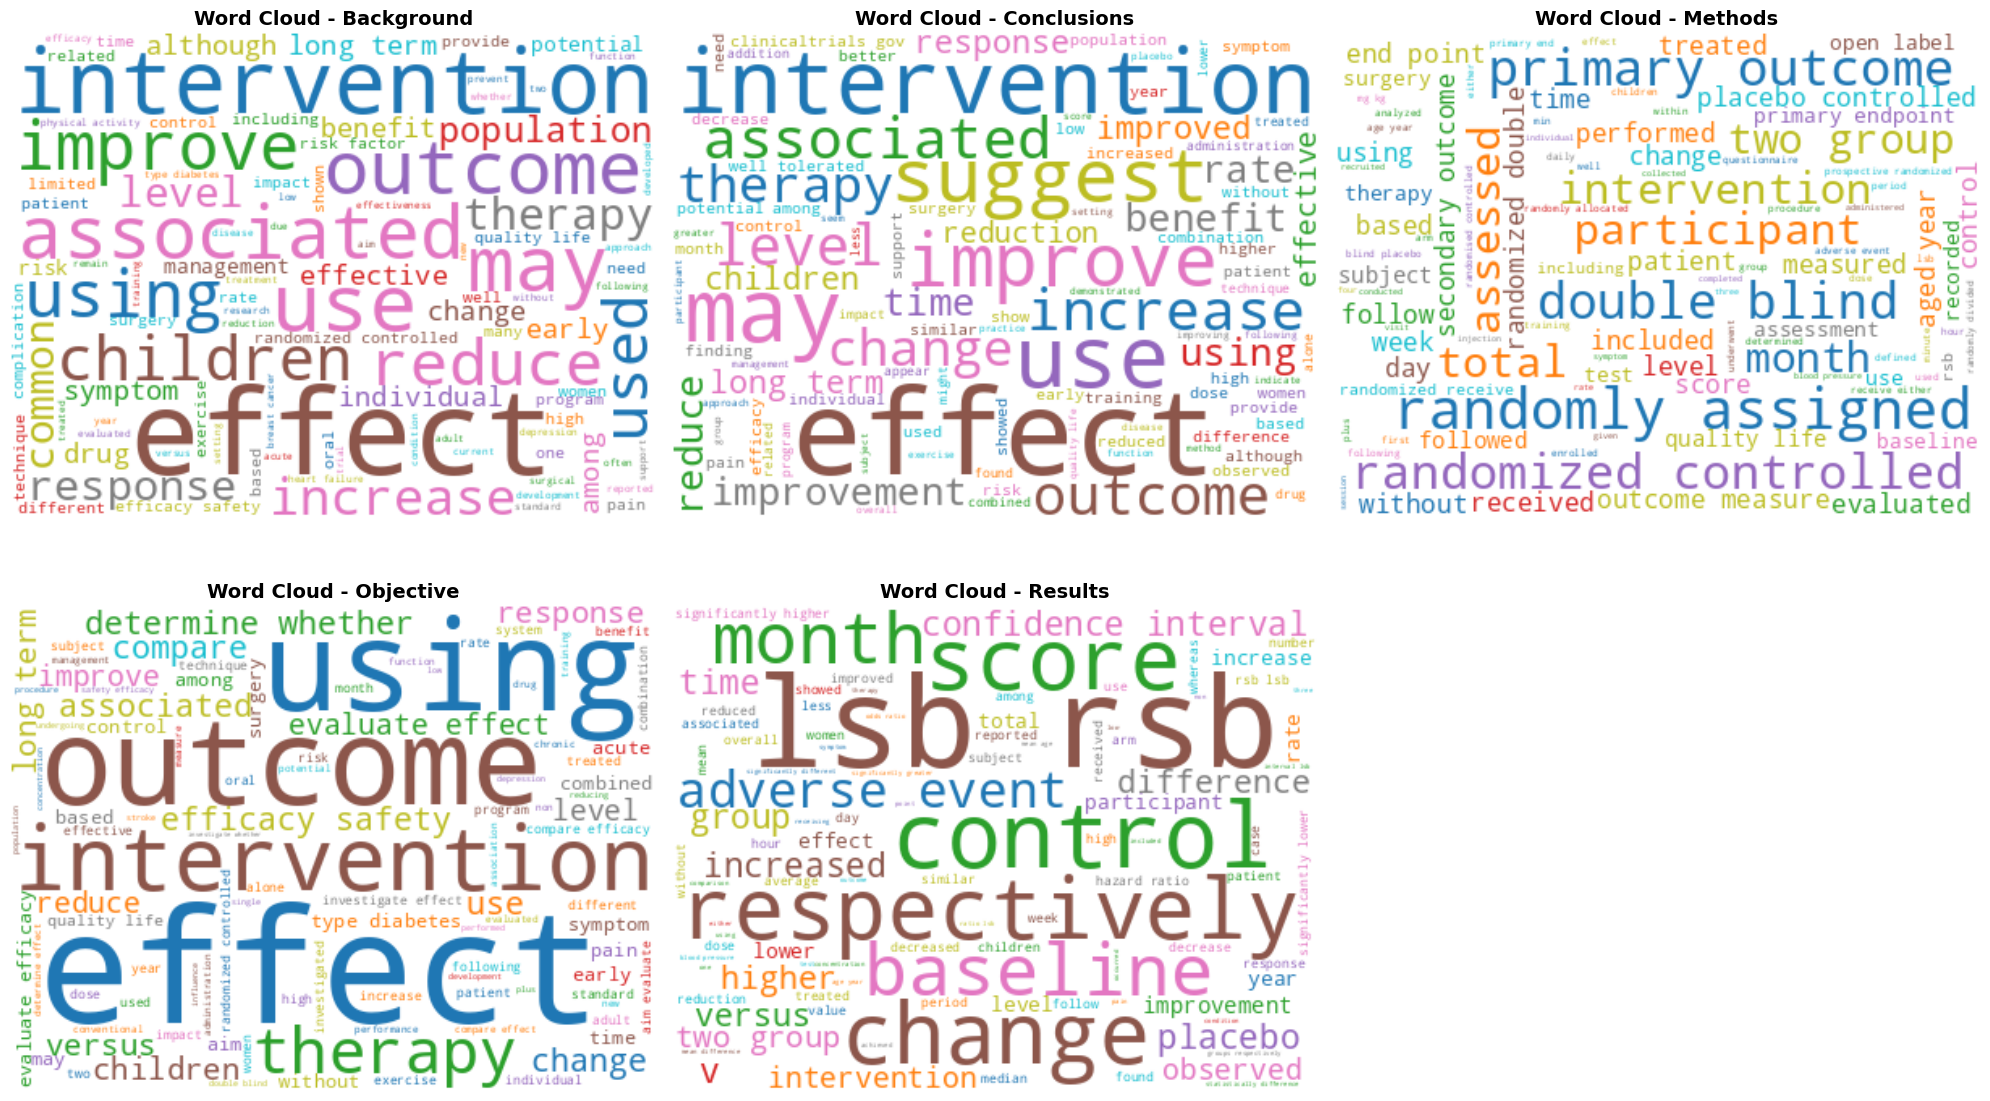

In [ ]:
# Word Cloud Generation
from wordcloud import WordCloud
import numpy as np

# Generate word clouds for each class
corpus = PubMedCorpus()  # Use full dataset
class_texts = {label: [] for label in unique_labels}

print("Generating word clouds from the full dataset...")
for example in corpus.get_raw_examples():
    if 'label' in example:
        label = example['label']
        text = example.get('text', '')
        # Remove stop words for better visualization
        tokens = word_tokenize(preprocess_string(text))
        filtered_text = ' '.join([word for word in tokens if word.lower() not in all_stopwords and len(word) > 2])
        class_texts[label].append(filtered_text)

# Create word clouds
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, label in enumerate(sorted(unique_labels)):
    if i < len(axes) and class_texts[label]:
        # Combine all texts for this class
        combined_text = ' '.join(class_texts[label])
        
        if combined_text.strip():
            # Generate word cloud
            wordcloud = WordCloud(
                width=400, 
                height=300,
                background_color='white',
                colormap=f'tab10',
                max_words=100,
                relative_scaling=0.5,
                random_state=42
            ).generate(combined_text)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'Word Cloud - {label.title()}', fontsize=14, fontweight='bold')
            axes[i].axis('off')

# Remove empty subplots
for i in range(len(unique_labels), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:04<00:00,  1.34s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: unlimited
Analyzing text lengths from the full dataset...


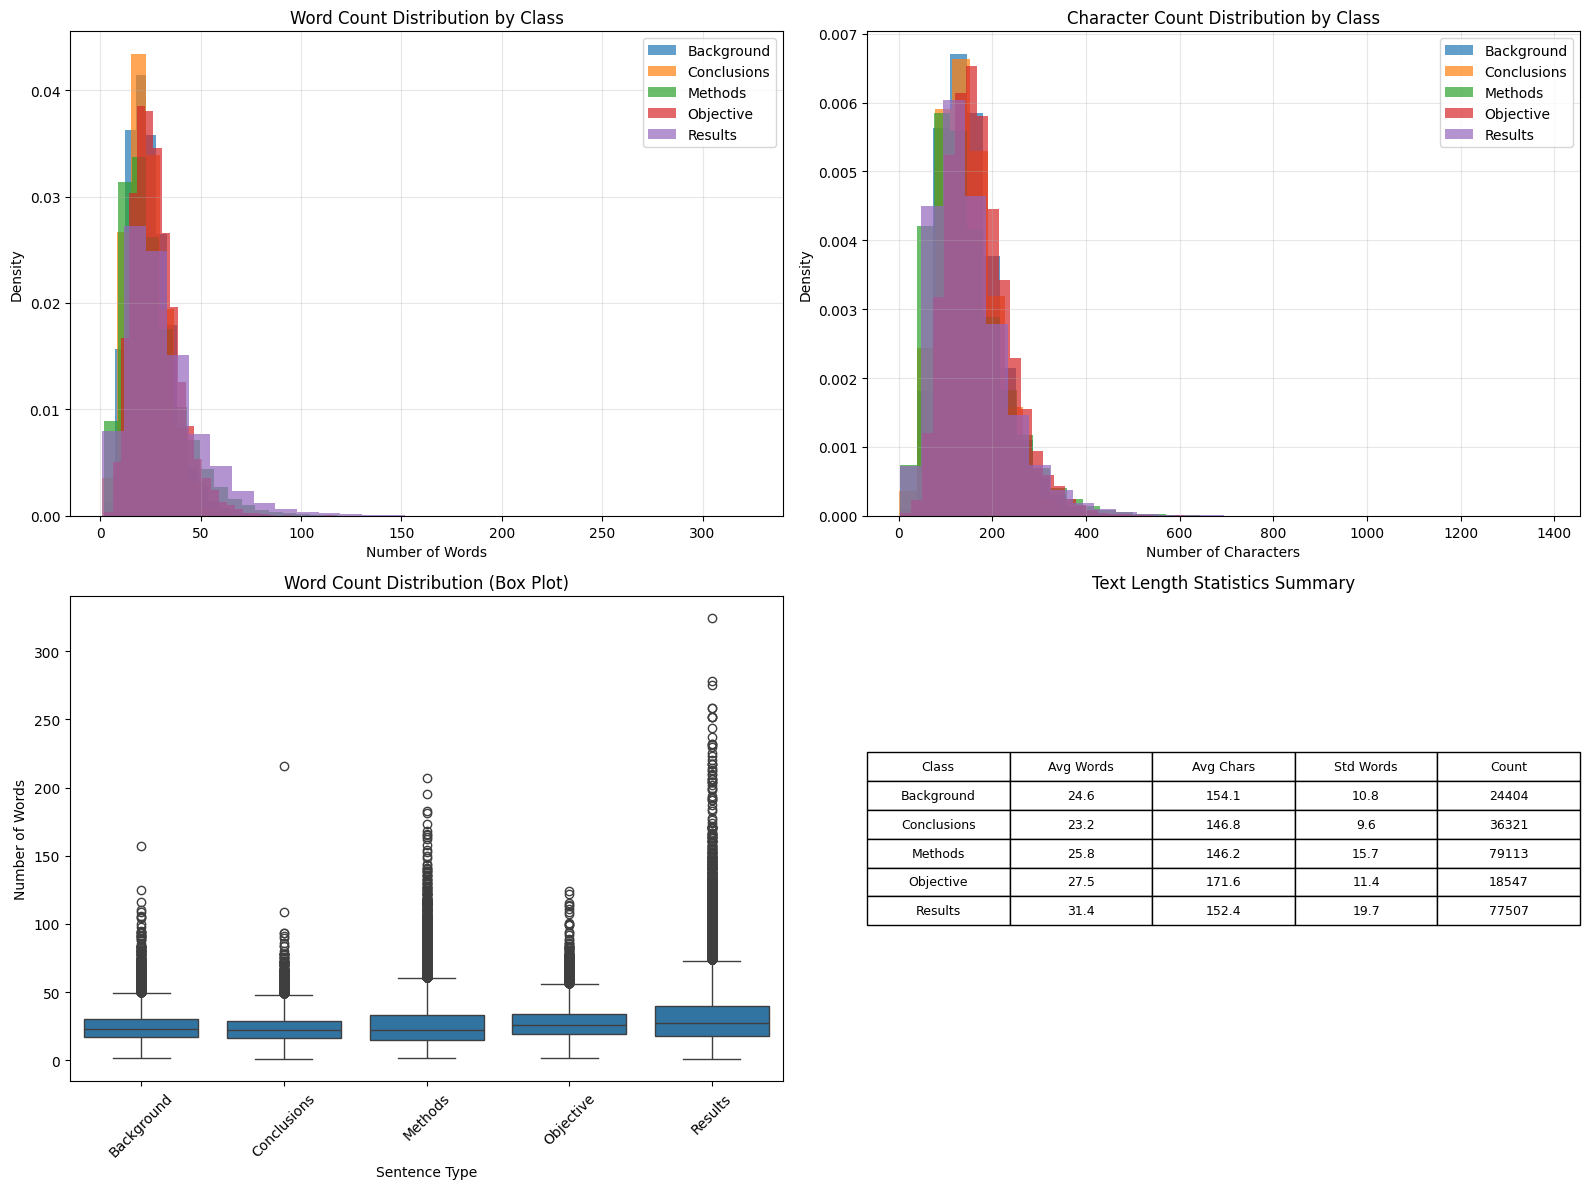


Text Length Statistics:

Background:
  Word count - Mean: 24.6, Std: 10.8
  Char count - Mean: 154.1, Std: 66.0
  Sample size: 24404

Conclusions:
  Word count - Mean: 23.2, Std: 9.6
  Char count - Mean: 146.8, Std: 61.5
  Sample size: 36321

Methods:
  Word count - Mean: 25.8, Std: 15.7
  Char count - Mean: 146.2, Std: 82.1
  Sample size: 79113

Objective:
  Word count - Mean: 27.5, Std: 11.4
  Char count - Mean: 171.6, Std: 67.7
  Sample size: 18547

Results:
  Word count - Mean: 31.4, Std: 19.7
  Char count - Mean: 152.4, Std: 81.1
  Sample size: 77507


In [ ]:
# Text Length Analysis - Histograms
corpus = PubMedCorpus()  # Use full dataset
text_lengths = {label: [] for label in unique_labels}

print("Analyzing text lengths from the full dataset...")
for example in corpus.get_raw_examples():
    if 'label' in example:
        label = example['label']
        text = example.get('text', '')
        # Count words and characters
        word_count = len(word_tokenize(text))
        char_count = len(text)
        text_lengths[label].append({'words': word_count, 'chars': char_count})

# Create comprehensive text length analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Word count distribution by class
ax1 = axes[0, 0]
for label in sorted(unique_labels):
    if text_lengths[label]:
        word_counts = [item['words'] for item in text_lengths[label]]
        ax1.hist(word_counts, bins=30, alpha=0.7, label=f'{label.title()}', density=True)

ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Density')
ax1.set_title('Word Count Distribution by Class')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Character count distribution by class
ax2 = axes[0, 1]
for label in sorted(unique_labels):
    if text_lengths[label]:
        char_counts = [item['chars'] for item in text_lengths[label]]
        ax2.hist(char_counts, bins=30, alpha=0.7, label=f'{label.title()}', density=True)

ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Density')
ax2.set_title('Character Count Distribution by Class')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Box plot for word counts
ax3 = axes[1, 0]
word_data = []
labels_for_box = []
for label in sorted(unique_labels):
    if text_lengths[label]:
        word_counts = [item['words'] for item in text_lengths[label]]
        word_data.extend(word_counts)
        labels_for_box.extend([label.title()] * len(word_counts))

box_df = pd.DataFrame({'words': word_data, 'class': labels_for_box})
sns.boxplot(data=box_df, x='class', y='words', ax=ax3)
ax3.set_title('Word Count Distribution (Box Plot)')
ax3.set_xlabel('Sentence Type')
ax3.set_ylabel('Number of Words')
ax3.tick_params(axis='x', rotation=45)

# Summary statistics
ax4 = axes[1, 1]
summary_stats = []
for label in sorted(unique_labels):
    if text_lengths[label]:
        word_counts = [item['words'] for item in text_lengths[label]]
        char_counts = [item['chars'] for item in text_lengths[label]]
        summary_stats.append({
            'Class': label.title(),
            'Avg Words': np.mean(word_counts),
            'Avg Chars': np.mean(char_counts),
            'Std Words': np.std(word_counts),
            'Count': len(word_counts)
        })

summary_df = pd.DataFrame(summary_stats)
ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=summary_df.round(1).values, 
                  colLabels=summary_df.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
ax4.set_title('Text Length Statistics Summary')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nText Length Statistics:")
for label in sorted(unique_labels):
    if text_lengths[label]:
        word_counts = [item['words'] for item in text_lengths[label]]
        char_counts = [item['chars'] for item in text_lengths[label]]
        print(f"\n{label.title()}:")
        print(f"  Word count - Mean: {np.mean(word_counts):.1f}, Std: {np.std(word_counts):.1f}")
        print(f"  Char count - Mean: {np.mean(char_counts):.1f}, Std: {np.std(char_counts):.1f}")
        print(f"  Sample size: {len(word_counts)}")

In [ ]:
# Visualize a complete abstract with color-coded sentences by class
from IPython.display import HTML
import matplotlib.colors as mcolors

# Load full dataset to get sentences for a specific abstract
corpus = PubMedCorpus()

# Collect all sentences for the first abstract (abstract_id index 0)
print("Loading sentences from the first abstract...")
abstract_sentences = []
first_abstract_id = None

for example in corpus.get_raw_examples():
    # Get the first abstract_id
    if first_abstract_id is None:
        first_abstract_id = example.get('abstract_id')
    
    # Collect all sentences from this abstract
    if example.get('abstract_id') == first_abstract_id:
        abstract_sentences.append({
            'sentence_id': example.get('sentence_id'),
            'label': example.get('label'),
            'text': example.get('text', '')
        })
    elif len(abstract_sentences) > 0:
        # We've moved to a different abstract, stop collecting
        break

# Sort sentences by sentence_id to maintain order
abstract_sentences.sort(key=lambda x: x['sentence_id'])

print(f"\nAbstract ID: {first_abstract_id}")
print(f"Number of sentences: {len(abstract_sentences)}\n")

# Define colors for each class
label_colors = {
    'background': '#FFE6E6',     # Light red
    'objective': '#E6F3FF',      # Light blue
    'methods': '#E6FFE6',        # Light green
    'results': '#FFF9E6',        # Light yellow
    'conclusions': '#F3E6FF'     # Light purple
}

# Create HTML visualization with colored sentences
html_parts = [f"<div style='font-family: Arial; line-height: 1.8; padding: 20px;'>"]
html_parts.append(f"<h3>Abstract ID: {first_abstract_id}</h3>")

# Add legend
html_parts.append("<div style='margin-bottom: 15px;'><strong>Legend:</strong> ")
for label, color in sorted(label_colors.items()):
    html_parts.append(f"<span style='background-color: {color}; padding: 3px 8px; margin: 0 5px; border-radius: 3px;'>{label.title()}</span>")
html_parts.append("</div>")

# Add colored sentences with justified text
html_parts.append("<div style='text-align: justify; margin-bottom: 20px;'>")
full_text_parts = []
for sent in abstract_sentences:
    label = sent['label']
    text = sent['text']
    color = label_colors.get(label, '#FFFFFF')
    
    html_parts.append(
        f"<span style='background-color: {color}; padding: 2px 4px; margin: 2px; "
        f"border-radius: 3px; display: inline;'>"
        f"<strong>[{label.upper()}]</strong> {text} </span>"
    )
    full_text_parts.append(f"[{label.upper()}] {text}")

html_parts.append("</div></div>")

# Display HTML
display(HTML(''.join(html_parts)))

# Also print plain text version
print("\n" + "="*80)
print("PLAIN TEXT VERSION:")
print("="*80)
for sent in abstract_sentences:
    print(f"\n[{sent['label'].upper()}] {sent['text']}")

🔄 Loading PubMed dataset (splits: train, validation, test)...


Loading dataset splits: 100%|██████████| 3/3 [00:03<00:00,  1.11s/split]


✅ Dataset loaded successfully! Splits: train, validation, test, Max examples: unlimited
Loading sentences from the first abstract...

Abstract ID: 24293578
Number of sentences: 12




PLAIN TEXT VERSION:

[OBJECTIVE] To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

[METHODS] A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

[METHODS] Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

[METHODS] Pain was assessed using the visual analog pain scale ( @-@ mm ) .

[METHODS] Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .

[METHODS] Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity 